# Categorical colors with sequential lightness

There are a lot of colormaps, but none of them solve my problem.

About 75% of my readers see my books in electronic forms where the figures are in color, and about 25% see them in grayscale.

Ideally, I would like to generate one version of each figure that looks good in color or grayscale.
And in particular I often have 2-4 lines that I need to distinguish.

I could use dashed and dotted lines, but then the color versions look pretty bad, in my opinion.

One solution is a palette of colors with:

* Categorical colors: That is, each color should be a distinctly different hue.

* Sequential lightness: When the colors are printed in grayscale, they should be equally-spaced in lightness.

The (highly informative) [documentation of Matplotlib colormaps](https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html) provides a good starting place.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## One hue, sequential lightness

I'll start with the purple sequential color scale.

In [2]:
from matplotlib import cm

cmap = cm.get_cmap('Purples_r')
cmap

We can select a range of shades from this colormap.

In [3]:
shades = np.linspace(0.0, 1.0, 101)

In [4]:
colors = cmap(shades)
colors.shape

(101, 4)

And extract their RGB values in a form we can use with `cspace_converter`.

In [5]:
rgb = colors[np.newaxis, :, :3]
rgb.shape

(1, 101, 3)

Now we can convert to LAB color space.

In [7]:
# If we're running on Colab, install colorspacious

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install colorspacious

In [8]:
from colorspacious import cspace_converter

lab = cspace_converter("sRGB1", "CAM02-UCS")(rgb)
lab.shape

ModuleNotFoundError: No module named 'colorspacious'

And extract the L component, lightness.

In [8]:
lightness = lab[0, :, 0]
lightness.shape

(101,)

Plotting lightness versus shade, we can see that the lightness of this color map is perceptually linear, except at the extreme right (which we're not going to use for plotting anyway).

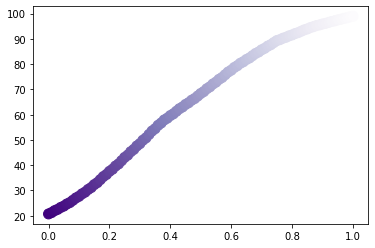

In [9]:
plt.scatter(shades, lightness, c=shades, cmap=cmap, s=100)

## Six hues, sequential lightness

Now I'll do the same thing with the other single-hue colormaps.

In [10]:
cmap_list = ['Greys_r', 'Purples_r', 
             'Blues_r', 'Greens_r', 
             'Oranges_r', 'Reds_r']

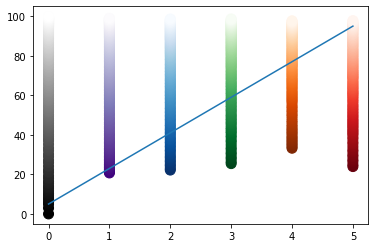

In [11]:
from colorspacious import cspace_converter

ones = np.full_like(shades, 1)
lightness_map = {}

for j, cmap_name in enumerate(cmap_list):
    # Get RGB values for colormap and convert the colormap in
    # CAM02-UCS colorspace.  lab[0, :, 0] is the lightness.
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(shades)[np.newaxis, :, :3]
    lab = cspace_converter("sRGB1", "CAM02-UCS")(rgb)

    # To make scatter markers change
    # color along plot:
    # http://stackoverflow.com/questions/8202605/

    x = j * ones
    lightness = lab[0, :, 0]
    lightness_map[cmap_name] = lightness

    plt.scatter(x, lightness, c=shades, cmap=cmap, s=100)

plt.plot([0, 5], [5, 95]);

In the figure above, we can see the range of lightness we can achieve with each hue.  The blue line shows a linear range of lightness, which we can use to select a color from each column.

Here are the lightnesses.

In [12]:
new_xs = np.linspace(5, 95, 6)
new_xs

array([ 5., 23., 41., 59., 77., 95.])

To select colors from each column I'll interpolate into the list of shades.

In [13]:
from scipy.interpolate import interp1d

custom_colors = []

for new_x, cmap_name in zip(new_xs, lightness_map):
    lightness = lightness_map[cmap_name]
    new_shade = interp1d(lightness, shades)(new_x)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(new_shade)
    custom_colors.append(rgb)
    
    print(cmap_name, new_x)
    print(rgb)

Greys_r 5.0
(0.022760476739715495, 0.022760476739715495, 0.022760476739715495, 1.0)
Purples_r 23.0
(0.2703114186851211, 0.04318339100346021, 0.5101268742791234, 1.0)
Blues_r 41.0
(0.07789311803152635, 0.37719338715878503, 0.6582852748942715, 1.0)
Greens_r 59.0
(0.20830449826989617, 0.6208842752787389, 0.3274279123414071, 1.0)
Oranges_r 77.0
(0.9921568627450981, 0.6036908881199539, 0.3075740099961553, 1.0)
Reds_r 95.0
(0.9976624375240293, 0.9116955017301038, 0.8710495963091118, 1.0)


## Let's see how they look

I'll adapt [this example](https://matplotlib.org/3.3.3/tutorials/intermediate/color_cycle.html) to show how this colormap looks in color and grayscale.

In [14]:
x = np.linspace(0, 2 * np.pi, 50)
offsets = np.linspace(0, -3, 6, endpoint=False)
yy = np.transpose([np.sin(x + phi) for phi in offsets])
yy.shape

(50, 6)

Here it is in color.

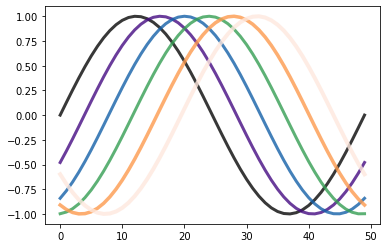

In [15]:
from cycler import cycler

lw = [3, 3, 3, 3, 3.5, 4]

custom_cycler = (cycler(color=custom_colors) +
                 cycler(lw=lw))

plt.gca().set_prop_cycle(custom_cycler)
plt.plot(yy, alpha=0.8);

And here it is in grayscale.

In [16]:
custom_grays = [str(x / 100) for x in new_xs]

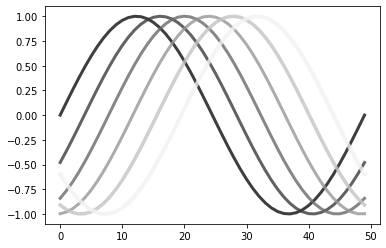

In [17]:
custom_cycler = (cycler(color=custom_grays) +
                 cycler(lw=lw))

plt.gca().set_prop_cycle(custom_cycler)
plt.plot(yy, alpha=0.8);

The lightest pink color doesn't look very good in color or grayscale, so it is probably not usable.  But I think the other five look good in color and are clearly distinguishable in grayscale.

My next step is to select subsets for plots that require 2, 3, or 4 different colors.